# Particle Cloud Simulation Example

<table><tr>
<td> <img src="RandomFlow.png" alt="Drawing" style="width: 200px;"/> </td>
<td> <img src="RandomFlow.gif" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

Here we simulate the trajectory of a particle cloud in a randomly generated flow field which is a crude representation for an ocean eddy field.

As an exercise left to the user, directions are provided e.g. to modify the size of the domain or the initial position of the particle cloud. 

The demonstrated methods that are generally applicable for research purposes (e.g. with flow field derived from models or data). The notebook also demoes simple methods to create plots and movies.

- 1. setup the software and initialize example
- 2. simulate trajectories & plot results
- 3. experiment with parameters (user)

### For More Documentation 

On Julia :
- <https://julialang.org>
- <https://docs.julialang.org>

On this notebook :
- <https://docs.juliadiffeq.org/latest> 
- <https://en.wikipedia.org/wiki/Displacement_(vector)>
- <https://juliaclimate.github.io/IndividualDisplacements.jl/dev>
- <https://juliaclimate.github.io/MeshArrays.jl/dev>

## 1.1 Import Software

In [1]:
using OrdinaryDiffEq, Plots, ColorSchemes
using IndividualDisplacements, MeshArrays
using Statistics, Random, DataFrames
p=dirname(pathof(MeshArrays)); include(joinpath(p,"../examples/Demos.jl"))
include("helper_functions.jl")

SetupRandomFlow

## 1.2 Setup Problem

Put grid variables in a dictionary.

In [2]:
np=24
Γ=SetupPeriodicDomain(np);

Derive flow field (`𝑃["u0"]` etc) from randomly generated ϕ streamfunction

In [3]:
𝑃,ϕ=SetupRandomFlow(Γ);

## 1.3 Initial Positions

Set the initial positions to a region of the gridded domain. These will provide the initial condition `u0` for the differential equation solver.

_Skipped at first in presentation mode_

In [4]:
x0=np*(0.25:0.02:0.75)
y0=np*(0.25:0.02:0.75)

#reformat data into u0 initial condition
x0=vec(x0)*ones(1,length(y0))
y0=ones(size(x0,1),1)*transpose(vec(y0))
u0=transpose([x0[:] y0[:] ones(size(x0[:]))]);

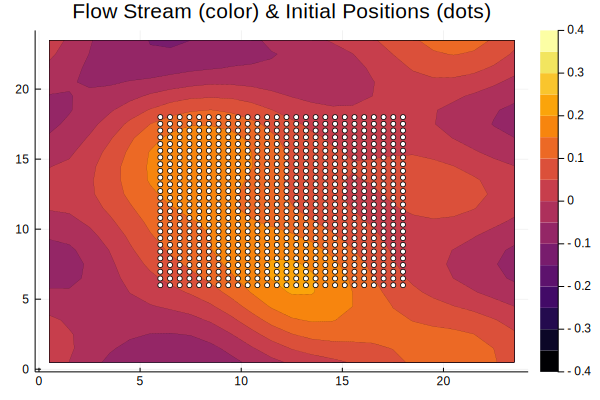

In [11]:
x=vec(Γ["XC"][1][:,1])
y=vec(Γ["YC"][1][1,:])
χ=transpose(ϕ[1])

plt=contourf(x,y,χ,linewidth = 0.1,clims=(-0.4,0.4),
             title="Flow Stream (color) & Initial Positions (dots)")
scatter!(plt,u0[1,:],u0[2,:],c=:white,markersize=3.0,leg=false)

#pth=tempdir()*"/"
#savefig(plt,pth*"RandomFlow.png")

## 2.1 Compute Trajectories

As done in the `SolidBodyRotation` example earlier, we simply use the `OrdinaryDiffEq` package to solve for the particle trajectories.

In [6]:
𝑇 = (𝑃["t0"],𝑃["t1"])
prob = ODEProblem(⬡!,u0,𝑇,𝑃)
sol = solve(prob,Tsit5(),reltol=1e-5,abstol=1e-5)
size(sol)

(3, 676, 575)

## 2.2 Post-Process Output

Reformat the `sol` output from the `solve` function into a `DataFrame` for practical use, plotting, etc.

_Code cell is skipped at first in presentation mode_

In [7]:
#x,y axes etc 
x=sol[1,:,:]
y=sol[2,:,:]
fIndex=sol[3,:,:]
ID=collect(1:size(sol,2))*ones(1,size(sol,3))

#put together as a DataFrame
df = DataFrame(ID=Int.(ID[:]), x=mod.(x[:],Ref(np)), y=mod.(y[:],Ref(np)), fIndex=fIndex[:]);

In [8]:
#add a time axis
nf=size(u0,2)
nt=size(df,1)/nf
t=[ceil(i/nf)-1 for i in 1:nt*nf]

df[!,:t]=(𝑃["t1"]-𝑃["t0"])/t[end].*t;

#df

## 2.3 Plot Results

- define `scatter_subset` convenience function
- generate animation using `scatter_subset`

In [9]:
function scatter_subset(df,t)
    dt=5.0
    df_t = df[ (df.t.>t-dt).&(df.t.<=t) , :]
    
    x=vec(Γ["XC"][1][:,1])
    y=vec(Γ["YC"][1][1,:])
    χ=transpose(ϕ[1])
    contourf(x,y,χ,c = :blues,linewidth = 0.1,clims=(-0.4,0.4),colorbar=false)

    scatter!(df_t.x,df_t.y,markersize=2.0,c=:red,
    xlims=(0,np),ylims=(0,np),leg=:none,marker = (:circle, stroke(0)))
end

scatter_subset (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /var/folders/1m/ddjxkwvn7bz7z9shdnh8q3040000gn/T/RandomFlow.gif
└ @ Plots /Users/gforget/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/var/folders/1m/ddjxkwvn7bz7z9shdnh8q3040000gn/T/RandomFlow.gif")
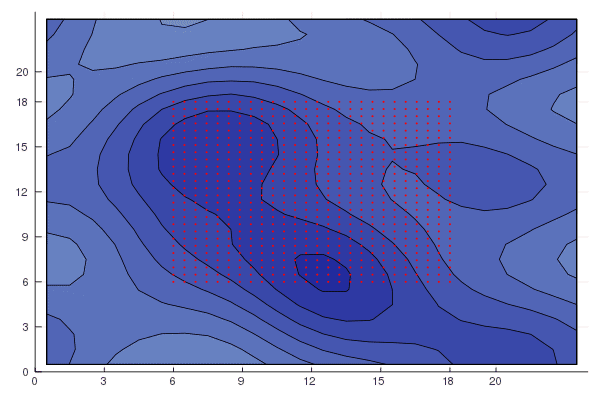

In [10]:
#@gif for t in 0:2.0:maximum(df[!,:t])
#   scatter_subset(df,t)
#end

anim = @animate for t in 0:2.0:maximum(df[!,:t])
   scatter_subset(df,t)
end
pth=tempdir()*"/"
gif(anim, pth*"RandomFlow.gif", fps = 15)